In [75]:
import numpy as np
import time
import torch

def ProjectOntoL1Ball(v, b):
    """Projects vector v onto the L1 ball with radius b."""
    if b < 0:
        raise ValueError(f"Radius of L1 ball is negative: {b:.3f}")
    if np.linalg.norm(v, ord=1) <= b:
        return v.copy()
    u = np.sort(np.abs(v))[::-1]  # Descending order
    sv = np.cumsum(u)
    rho = np.where(u > (sv - b) / np.arange(1, len(u) + 1))[0]
    if rho.size == 0:
        theta = 0.0
    else:
        rho_idx = rho[-1]
        theta = (sv[rho_idx] - b) / (rho_idx + 1)
    w = np.sign(v) * np.maximum(np.abs(v) - theta, 0)
    return w

def DBGD(fun_f, grad_f, grad_g, fun_g, TSA, param, x0):
    """Dynamic Barrier Gradient Descent algorithm."""
    stepsize = param['stepsize']
    alpha = param['alpha']
    beta = param['beta']
    lambda_ = param['lam']  # Avoid 'lambda' keyword
    maxiter = param['maxiter']
    maxtime = param['maxtime']
    
    x = x0.copy()
    start_time = time.time()
    iter_count = 0
    f_vec1, g_vec1, time_vec1, acc_vec = [], [], [], []
    d_vec = []
    grad_g_norm_vec = []
    while iter_count <= maxiter:
        # x_prev = x
        iter_count += 1
        stepsize = stepsize / iter_count**(1/3)
        grad_f_x = grad_f(x)
        grad_g_x = grad_g(x)
        grad_g_norm_vec.append(np.linalg.norm(grad_g_x))
        # Compute phi and weight (lambda_k)
        g_x = fun_g(x)
        grad_g_sq = np.dot(grad_g_x, grad_g_x)
        phi = grad_g_sq
        
        denominator = grad_g_sq
        if denominator == 0:
            weight = 0.0
        else:
            numerator = phi - np.dot(grad_f_x, grad_g_x)
            weight = max(numerator / denominator, 0.0)
        
        v = grad_f_x + weight * grad_g_x
        x = x - stepsize * v
        d_vec.append(np.linalg.norm(v))
        # Projection onto L1 ball
        # x = ProjectOntoL1Ball(x, lambda_)
        
        # Record metrics
        elapsed = time.time() - start_time
        f_vec1.append(fun_f(x))
        g_vec1.append(fun_g(x))
        # time_vec1.append(elapsed)
        time_vec1.append(iter_count)
        acc_vec.append(TSA(x))
        
        # Log progress
        if iter_count % 5000 == 0:
            print(f"Iteration: {iter_count}")
        
        # Check time constraint
        if elapsed > maxtime:
            break
        
        # iter_count += 1
    
    # Convert lists to numpy arrays
    return (
        np.array(f_vec1),
        np.array(g_vec1),
        np.array(time_vec1),
        x,
        np.array(acc_vec),
        np.array(d_vec),
        np.array(grad_g_norm_vec)
    )

f_type = 'type3'
center = np.array([0, 1.25313])

if f_type == 'type1':
    def example_f(x):
        return (x[0] - 1)**2 + (x[1] + 10)**2

    def example_grad_f(x):
        return np.array([2*(x[0] - 1), 2*(x[1] + 10)])
    
if f_type == 'type2':
    def example_f(x):
        return (x[0])**2 + (x[1])**2

    def example_grad_f(x):
        return np.array([2*x[0], 2*x[1]])   

if f_type == 'type3':
    def example_f(x):
        return (x[0] - center[0])**2 + (x[1] - center[1])**2

    def example_grad_f(x):
        return np.array([2*(x[0] - center[0]), 2*(x[1] - center[1])])

# Example test functions
def example_f(x):
    return (x[0] - 1)**2 + (x[1] + 10)**2

def example_grad_f(x):
    return np.array([2*(x[0] - 1), 2*(x[1] + 10)])

g_type = 'type5'

if g_type == 'type1':
    def example_g(x):
        """The complex function using numpy for regular evaluation"""
        # Add clipping to prevent overflow
        r = np.sqrt(x[0]**2 + x[1]**2)
        exp_term = np.exp(1 - r / np.pi)
        return -abs(np.sin(x[0]) * np.cos(x[1]) * exp_term)

    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute function using PyTorch operations with more stable computation
        r = torch.sqrt(x_torch[0]**2 + x_torch[1]**2)
        exp_term = torch.exp(torch.clamp(1 - r / np.pi, min=-100, max=100))
        y = -torch.abs(torch.sin(x_torch[0]) * torch.cos(x_torch[1]) * exp_term)
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)):
            print(f"Warning: NaN gradient detected at x={x}")
            # Return zero gradient instead of NaN
            return np.zeros_like(x)
        
        return grad
if g_type == 'type2':
    def example_g(x):
        return (x[1] - np.sin(x[0]))**2

    def example_grad_g(x):
        return np.array([
            -2 * np.cos(x[0]) * (x[1] - np.sin(x[0])),
            2 * (x[1] - np.sin(x[0]))
        ])
    
if g_type == 'type3':
    def example_g(x):
        return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

    def example_grad_g(x):
        # Gradient of g with respect to x[0] and x[1]
        dx = 2*(x[0]**2 + x[1] - 11)*(2*x[0]) + 2*(x[0] + x[1]**2 - 7)
        dy = 2*(x[0]**2 + x[1] - 11) + 2*(x[0] + x[1]**2 - 7)*(2*x[1])
        return np.array([dx, dy])
    
if g_type == 'type4':
    def example_g(x):
        """The complex function using numpy for regular evaluation"""
        r = np.sqrt(x[0]**2 + x[1]**2)
        exp_term = np.exp(100 - r / np.pi)
        inner_term = abs(np.sin(x[0]) * np.sin(x[1]) * exp_term) + 1
        return -0.0001 * (inner_term ** 0.1)

    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute function using PyTorch operations with more stable computation
        r = torch.sqrt(x_torch[0]**2 + x_torch[1]**2 + 1e-8)  # Add small epsilon for stability
        exp_term = torch.exp(torch.clamp(100 - r / np.pi, min=-50, max=50))  # Clamp exponential
        sin_term = torch.sin(x_torch[0]) * torch.sin(x_torch[1])
        inner_term = torch.abs(sin_term * exp_term) + 1
        y = -0.0001 * (inner_term ** 0.1)
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            # Instead of returning zeros, return a small gradient in the direction of x
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad
    
if g_type == 'type5':
    def example_g(x):
        """The complex function using numpy for regular evaluation"""
        # Compute intermediate terms
        x_sq_minus_y_sq = x[0]**2 - x[1]**2
        squared_norm = x[0]**2 + x[1]**2
        denominator = (1 + 0.001 * squared_norm)**2
        
        # Compute the full function
        return 0.5 + (np.cos(np.sin(x_sq_minus_y_sq))**2 - 0.5) / denominator

    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute intermediate terms
        x_sq_minus_y_sq = x_torch[0]**2 - x_torch[1]**2
        squared_norm = x_torch[0]**2 + x_torch[1]**2
        denominator = (1 + 0.001 * squared_norm)**2
        
        # Compute the full function
        y = 0.5 + (torch.cos(torch.sin(x_sq_minus_y_sq))**2 - 0.5) / denominator
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad
    

# Dummy test set accuracy function
def dummy_TSA(x):
    return 0.0

# Example parameters
param = {
    'stepsize': 0.05,
    'alpha': 1,
    'beta': 1,
    'lam': 1.0,
    'maxiter': 10000,
    'maxtime': 10  # seconds
}

# Initial point
# init_point = 10000
x0 = np.array([0.0, 1.0])

# Run DBGD
f_values, g_values, time_values, x_final, acc_values, d_values, grad_g_norm_values = DBGD(
    example_f, example_grad_f, example_grad_g, example_g, dummy_TSA, param, x0
)

Iteration: 5000
Iteration: 10000


In [96]:
print(d_values)
print(grad_g_norm_values)

[18.6762947  18.32369507 17.94612064 ...  0.02073589  0.02066643
  0.02059841]
[0.00431426 0.00426197 0.00421747 ... 0.0076078  0.00760751 0.00760721]


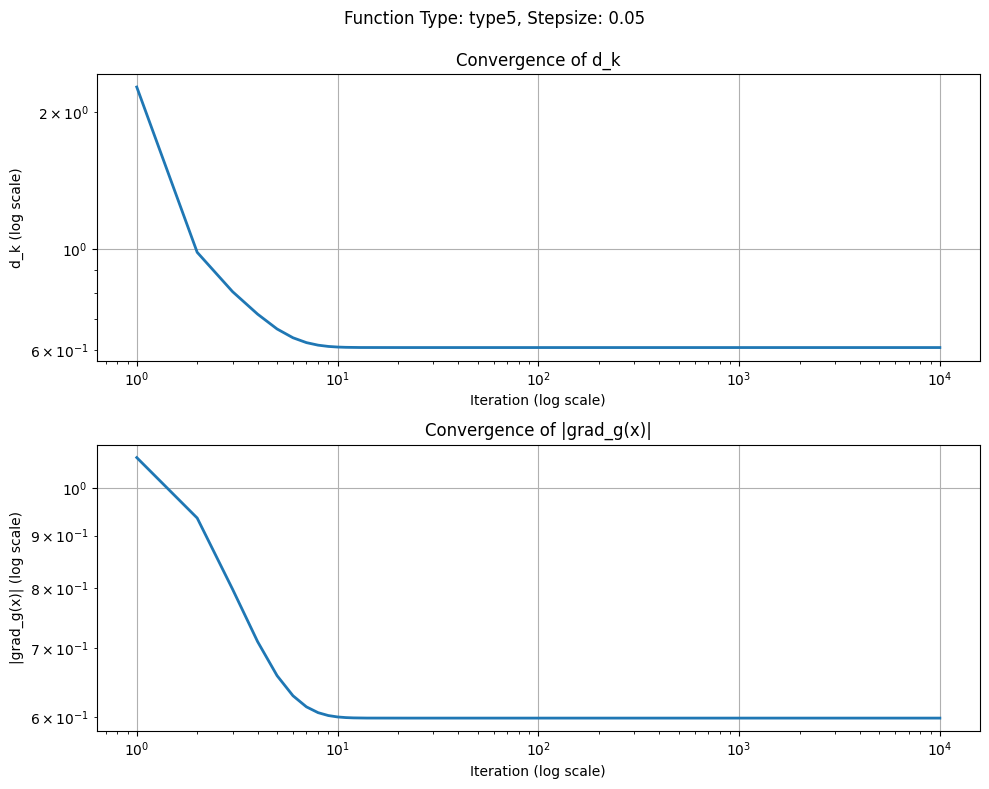

In [76]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot f(x) in first subplot
ax1.loglog(time_values, d_values, linewidth=2)
ax1.set_xlabel('Iteration (log scale)')
ax1.set_ylabel('d_k (log scale)')
ax1.set_title('Convergence of d_k')
ax1.grid(True)

# Plot g(x) in second subplot
ax2.loglog(time_values, grad_g_norm_values, linewidth=2)
ax2.set_xlabel('Iteration (log scale)')
ax2.set_ylabel('|grad_g(x)| (log scale)')
ax2.set_title('Convergence of |grad_g(x)|')
ax2.grid(True)

# Add main title showing type and stepsize
plt.suptitle(f'Function Type: {g_type}, Stepsize: {param["stepsize"]}', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Make room for suptitle

# Show the plot
plt.show()